# TUTORIAL USING ROMANIAN BERT

In this post we will take a pretrained model and we will create a classifiers on top of it.

## Install dependencies ##

In [ ]:
!pip3 install transformers tokenizers pytorch-lightning torch

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import *
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from imbalanced_sampler import ImbalancedDatasetSampler
from argparse import Namespace
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
torch.__version__

'1.4.0'

### Load Pre-Trained BERT ###

In [3]:
tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
config = BertConfig.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1", output_hidden_states=True)
model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1", config=config)

INFO:transformers.tokenization_utils:Model name 'dumitrescustefan/bert-base-romanian-cased-v1' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1). Assuming 'dumitrescustefan/bert-base-romanian-cased-v1' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file dumitrescustefan/bert-base-romanian-cased-v1/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file dumitrescustefan/bert-base-romanian-cased-v1

In [4]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## Tokenize Input

In [5]:
sentence = "Am împrumutat cartea acesta."
mark_sentence = "[CLS]" + sentence + "[SEP]"
tokenized_sentence = tokenizer.tokenize(mark_sentence)
enc_sentence = tokenizer.encode(sentence)
print("Tokenized sentence is: {} and it has the following ids : {}".format(tokenized_sentence, enc_sentence))

Tokenized sentence is: ['[CLS]', 'am', 'imprumut', '##at', 'cartea', 'acesta', '.', '[SEP]'] and it has the following ids : [2, 474, 48617, 368, 4435, 1330, 18, 3]


In [6]:
list(tokenizer.vocab.keys())[5000:5020]

['controlul',
 'schimba',
 '##alia',
 'împrum',
 '##năsti',
 'acordat',
 'aste',
 '##ction',
 '##atia',
 '2003',
 'mașini',
 'PNL',
 'dans',
 'anexa',
 '##cilor',
 '##osc',
 'învin',
 'Transilv',
 'oa',
 '##anților']

In [7]:
##create new example with omonymns
sentences = "Prințesa a sărutat broasca dar aceasta nu s-a transformat in prinț." \
            "Nu am găsit cheia ca să deschid broasca de la ușă."

# Add the special tokens.
mark_sentences = "[CLS] " + sentences + " [SEP]"

# Tokenize sentences into tokens
tokenized_sentences = tokenizer.tokenize(mark_sentences)

# Map tokens to ids in vocabulary
ids_sentences = tokenizer.encode(mark_sentences)

for tok, id in zip(tokenized_sentences, ids_sentences):
    print("{}\t{}".format(tok, id))

[CLS]	2
printesa	2
a	42240
sar	69
##utat	2610
broa	3452
##sca	38130
dar	2298
aceasta	592
nu	1239
s	411
-	87
a	17
transformat	69
in	8057
print	402
.	24930
nu	18
am	411
gasit	474
cheia	10177
ca	12685
sa	416
deschid	446
broa	14180
##sca	38130
de	2298
la	363
usa	392
.	19386
[SEP]	18


In [8]:
ids_segments = [1] * len(ids_sentences)

print(ids_segments)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [9]:
input_tensor = torch.tensor(ids_sentences).unsqueeze(0)  # Batch size 1
segments_tensor = torch.tensor(ids_segments).unsqueeze(0) # batch size 1 

with torch.no_grad():
    outputs = model(input_tensor, segments_tensor)

In [10]:
## Understand output layers
last_hidden_states = outputs[0]
# tensor of shape (batch_size, sequence_length, hidden_size)

pooler_output = outputs[1]
# tensor of shape (batch_size, hidden_size)

hidden_states = outputs[2]
# list of tensors of shape (batch_size, hidden_size)

In [11]:
print ("Number of layers:", len(hidden_states))
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13
Number of batches: 1
Number of tokens: 33
Number of hidden units: 768


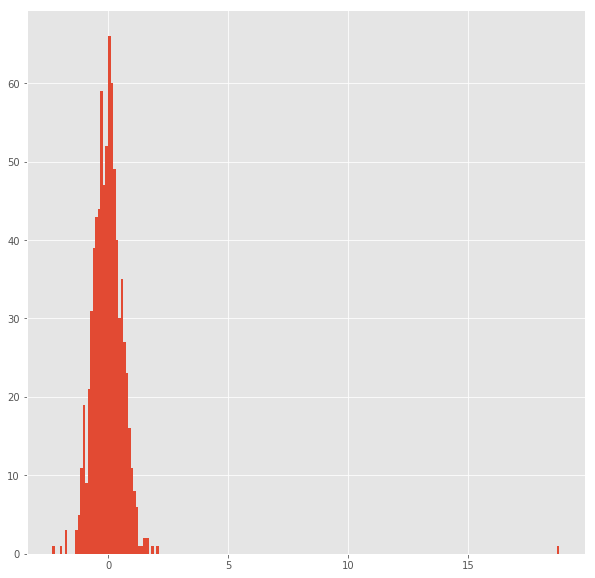

In [12]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 3
layer_i = 7
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [13]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings = token_embeddings.squeeze(1)
token_embeddings.size()

torch.Size([13, 33, 768])

## Create embedding representations for words and sentences

### Word Embeddings ###

In [14]:
def get_tokkens_embeddings_concat(sentence, max_length=16):
    # list with tokens embeddings for each token
    token_vecs_concat = []
    
    ids_sentences = tokenizer.encode(sentence, add_special_tokens=True,
                                    pad_to_max_length=True,
                                    max_length=max_length)
    ids_segments = [1] * len(ids_sentences)
    input_tensor = torch.tensor(ids_sentences).unsqueeze(0)  # Batch size 1
    segments_tensor = torch.tensor(ids_segments).unsqueeze(0) # batch size 1 

    with torch.no_grad():
        _, _, hidden_states = model(input_tensor, segments_tensor)
                                    
    token_embeddings = torch.stack(hidden_states, dim=0).squeeze(1).permute(1,0,2)

    # For each token in the sentence...
    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4], token[-5], token[-6]), dim=0)

        token_vecs_concat.append(cat_vec)
        
    return token_vecs_concat

tokens_emb = get_tokkens_embeddings_concat("Eu am fost in Vama Veche.")
print ('Shape is: %d x %d' % (len(tokens_emb), len(tokens_emb[0])))

Shape is: 16 x 4608


In [15]:
def get_tokkens_embeddings_summ(sentence, max_length=16):
    token_vecs_summ = []

    ids_sentences = tokenizer.encode(sentence, add_special_tokens=True,
                                    pad_to_max_length=True,
                                    max_length=max_length)
    ids_segments = [1] * len(ids_sentences)
    input_tensor = torch.tensor(ids_sentences).unsqueeze(0)  # Batch size 1
    segments_tensor = torch.tensor(ids_segments).unsqueeze(0) # batch size 1 

    with torch.no_grad():
        _, _, hidden_states = model(input_tensor, segments_tensor)
                                    
    token_embeddings = torch.stack(hidden_states, dim=0).squeeze(1).permute(1,0,2)
    
    # For each token in the sentence...
    for token in token_embeddings:
        sum_vec = torch.sum(token[-6:], dim=0)

        token_vecs_summ.append(sum_vec)

    return token_vecs_summ
    
tokens_emb = get_tokkens_embeddings_summ("Aceasta este o propozitie.")
print ('Shape is: %d x %d' % (len(tokens_emb), len(tokens_emb[0])))

Shape is: 16 x 768


In [16]:
def tokens_similarity(tokens_emb, idx1, idx2):
    
    tok1_emb = tokens_emb[idx1]
    tok2_emb = tokens_emb[idx2]

    output = cosine(tok1_emb, tok2_emb)
    
    return 1-output

In [17]:
sentence1 = "Am mers pe lac si am inotat in lac."
sentence2 = "Lebedele inotau pe lac si am dat cu lac pe unghii."
tokens_emb1 = get_tokkens_embeddings_concat(sentence1)
tokens_emb2 = get_tokkens_embeddings_concat(sentence2)

print(tokens_similarity(tokens_emb1, 3, 9))
print(tokens_similarity(tokens_emb2, 6, 11))

0.754744827747345
0.588172972202301


### Sentence Embeddings ###

In [18]:
def get_sentence_embeddings(sentence, max_length=16):
    
    ids_sentences = tokenizer.encode(sentence, add_special_tokens=True,
                                    pad_to_max_length=True,
                                    max_length=max_length)
    ids_segments = [1] * len(ids_sentences)
    input_tensor = torch.tensor(ids_sentences).unsqueeze(0)  # Batch size 1
    segments_tensor = torch.tensor(ids_segments).unsqueeze(0) # batch size 1 

    with torch.no_grad():
        _, _, hidden_states = model(input_tensor, segments_tensor)
    
    token_vecs = hidden_states[12][0]

    sentence_embedding = torch.mean(token_vecs, dim=0)
    
    return sentence_embedding

In [19]:
def sentence_similarity(sent1, sent2):
    
    sent1_emb = get_sentence_embeddings(sent1)
    sent2_emb = get_sentence_embeddings(sent2)
    
    output = cosine(sent1_emb, sent2_emb)
    
    return 1-output

In [20]:
sentence1 = "Am fost la doctor la un control"
sentence2 = "Medicul a operat in salon"
sentence3 = "Nu am fost niciodata atat de vesela"

print(sentence_similarity(sentence1, sentence2))
print(sentence_similarity(sentence2, sentence3))
print(sentence_similarity(sentence1, sentence3))

0.8724686503410339
0.7341930866241455
0.7526881098747253


## SENTENCE CLASSIFICATION WITH BERT ##

### Data Exploration ###

In [96]:
# Load Data
df = pd.read_csv("./ro/train.csv")
df.dropna(inplace=True)
df.label = df.label.astype('category')
train_df = df.iloc[:15000]
validation_df = df.iloc[15000:]
test_df = pd.read_csv("./ro/test.csv")
test_df.dropna(inplace=True)

In [97]:
validation_df.describe()

,index
count,2651.000000
mean,5517.340626
std,768.211096
min,4187.000000
25%,4852.500000
50%,5516.000000
75%,6183.500000
max,6846.000000


Text(0.5, 1.0, 'Training Label Distribution')

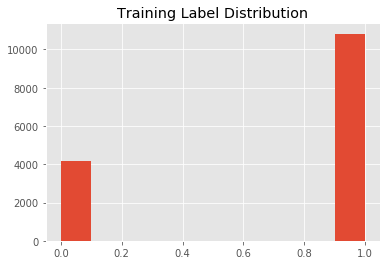

In [98]:
train_df.label.hist()
plt.title("Training Label Distribution")

In [99]:
pd.options.display.max_colwidth = 512
train_df.head()

,index,text,label
0,0,"acest document mi-a deschis cu adevarat ochii la ceea ce oamenii din afara statelor unite s-au gandit la atacurile din 11 septembrie. acest film a fost construit in mod expert si prezinta acest dezastru ca fiind mai mult decat un atac asupra pamantului american. urmarile acestui dezastru sunt previzionate din multe tari si perspective diferite. cred ca acest film ar trebui sa fie mai bine distribuit pentru acest punct. de asemenea, el ajuta in procesul de vindecare sa vada in cele din urma altceva decat...",1
1,1,"tine mancarea rece. ce altceva ii mai trebuie?\nam frigiderul de vreun an, utilizare continua.\nzgomotul e decent spre scazut daca esti in aceeasi incapere cu el. nu il auzi din dormitory cu usile inchise.\ne un frigider ce sa zici despre el?\no sa tina mancarea rece, la temperaturile indicate. recomand sa spalati bine dispenserul de lichide dupa utilizare ca sa nu se contamineze apa. da asta e de bun simt: d",1
2,2,excelent\nrecomand!,1
3,3,"ca un rocker imbatranit, acest film mentioneaza heep and quo - cele doua trupe preferate ale mele vreodata - dar cu o distributie incredibila (toata lumea) - si povestea fantastica - imi place doar aceasta piesa de geniu creativ. nu-l pot recomanda mai mult - si mick jones a adaugat atat de mult (leaderul si scriitorul principal alaturi de cel mai mare cantaret rock - lou gramm) - am vazut aceasta mare lucrare mai mult de 10 ori - bill nighy - ce voce - si jimmy nail - talentul risipeste de la fiecare p...",1
4,4,"ei bine, a facut o groaza veche si foarte intunecata in casa. setare buna, care include personajul lui poe, el insusi, facand referire la poveste intr-un pub din londra. desi de aici este destul de mult un tip care a luat indrazneala sa viziteze casa intr-o noapte speciala care ruleaza din camera in camera, fie cauta sau evita oameni, este inca cea mai placuta. in plus, avem incantatoarea si enigmatica barbara steele. exista un dialog din lemn si niste biti si boboci inexplicabili, dar este atmosfera su...",1


In [100]:
train_df.values[1][1]

'tine mancarea rece. ce altceva ii mai trebuie?\nam frigiderul de vreun an, utilizare continua.\nzgomotul e decent spre scazut daca esti in aceeasi incapere cu el. nu il auzi din dormitory cu usile inchise.\ne un frigider ce sa zici despre el?\no sa tina mancarea rece, la temperaturile indicate. recomand sa spalati bine dispenserul de lichide dupa utilizare ca sa nu se contamineze apa. da asta e de bun simt: d'

### Activation function ###

In [101]:
@torch.jit.script
def mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    See additional documentation for mish class.
    '''
    return input * torch.tanh(F.softplus(input))

In [102]:
class Mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        >>> m = Mish()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return mish(input)

In [103]:
class SentimentModel(nn.Module):
    
    def __init__(self, model,
                output_size,
                embedding_size=768,
                dropout=0.1
                ):
        super().__init__()
        self.model = model
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embedding_size, embedding_size)
        self.fc2 = nn.Linear(embedding_size, output_size)
        self.activation = Mish()
    
    def forward(self, X):
        
        ids_sentences = [tokenizer.encode(text, add_special_tokens=True,
                                        pad_to_max_length=True,
                                        max_length=128) for text in X]
        input_tensor = torch.tensor(ids_sentences)
        
        with torch.no_grad():
            last_hidden_state, _, hidden_states = self.model(input_tensor)

        sent_emb = last_hidden_state[:, 0, :]

        output = self.activation(self.dropout(self.fc1(sent_emb)))
        output = self.dropout(self.fc2(output))

        return output

In [104]:
classifier = SentimentModel(model, output_size=2)

In [105]:
# testing the classifier
ids_sentences = ("Ma simt foate rau.","Ma simt foate rau.")

classifier(ids_sentences)

tensor([[ 0.3171, -0.0678],
        [ 0.0000, -0.0007]], grad_fn=<MulBackward0>)

In [106]:
class SentimentDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.data = df
        
    def __getitem__(self, idx):
        return self.data.values[idx][1], self.data.values[idx][2]
    
    def __len__(self):
        return len(self.data)

In [107]:
train_dataset = SentimentDataset(train_df)
train_dataset[12]

('distractie excelenta de la inceput pana la sfarsit. spectacole minunate de belushi, beach, dalton & railsback. unele rasturnari si multe scene de actiune. filmul a fost facut pentru mine! linii amuzante in scenariu, muzica buna. dalton ca seriful dur si railsback ca "raufacator". trebuie sa recomand acest film tuturor fanilor de actiune si aventura! 10/10',
 1)

In [108]:
lr=5e-4

In [109]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = SentimentModel(model, output_size=2)
        self.loss = nn.CrossEntropyLoss()
        self.hparams = hparams
        
    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        print({ ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}})
        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}
    
    def forward(self, X):
        return self.model(X)
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "valid")
    
    def validation_end(self, outputs):
        loss = torch.stack([x["valid_loss"] for x in outputs]).mean()
        return {"valid_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_df, shuffle=True)
    
    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_df)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_df)
                
    def create_data_loader(self, df, shuffle=False):
        return DataLoader(
                    SentimentDataset(df),
                    batch_size=self.hparams.batch_size,
                    shuffle=False
                    )
    
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

In [110]:
hparams = Namespace(
    train_df=train_df,
    test_df=test_df,
    val_df=validation_df,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams)

In [111]:
## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(gpus=0, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

INFO:lightning:GPU available: False, used: False
INFO:lightning:
    | Name                                                    | Type              | Params
------------------------------------------------------------------------------------------
0   | model                                                   | SentimentModel    | 125 M 
1   | model.model                                             | BertModel         | 124 M 
2   | model.model.embeddings                                  | BertEmbeddings    | 38 M  
3   | model.model.embeddings.word_embeddings                  | Embedding         | 38 M  
4   | model.model.embeddings.position_embeddings              | Embedding         | 393 K 
5   | model.model.embeddings.token_type_embeddings            | Embedding         | 1 K   
6   | model.model.embeddings.LayerNorm                        | LayerNorm         | 1 K   
7   | model.model.embeddings.dropout                          | Dropout           | 0     
8   | model.model.encoder

{'valid_loss': tensor(0.6526), 'log': {'valid_loss': tensor(0.6526)}, 'progress_bar': {'valid_loss': tensor(0.6526)}}
{'valid_loss': tensor(0.6508), 'log': {'valid_loss': tensor(0.6508)}, 'progress_bar': {'valid_loss': tensor(0.6508)}}
{'valid_loss': tensor(0.6414), 'log': {'valid_loss': tensor(0.6414)}, 'progress_bar': {'valid_loss': tensor(0.6414)}}
{'valid_loss': tensor(0.6631), 'log': {'valid_loss': tensor(0.6631)}, 'progress_bar': {'valid_loss': tensor(0.6631)}}
{'valid_loss': tensor(0.6411), 'log': {'valid_loss': tensor(0.6411)}, 'progress_bar': {'valid_loss': tensor(0.6411)}}


{'loss': tensor(0.7634, grad_fn=<NllLossBackward>), 'log': {'train_loss': tensor(0.7634, grad_fn=<NllLossBackward>)}, 'progress_bar': {'train_loss': tensor(0.7634, grad_fn=<NllLossBackward>)}}
{'loss': tensor(0.7698, grad_fn=<NllLossBackward>), 'log': {'train_loss': tensor(0.7698, grad_fn=<NllLossBackward>)}, 'progress_bar': {'train_loss': tensor(0.7698, grad_fn=<NllLossBackward>)}}
{'loss': tensor(0.7846, grad_fn=<NllLossBackward>), 'log': {'train_loss': tensor(0.7846, grad_fn=<NllLossBackward>)}, 'progress_bar': {'train_loss': tensor(0.7846, grad_fn=<NllLossBackward>)}}
{'loss': tensor(0.7392, grad_fn=<NllLossBackward>), 'log': {'train_loss': tensor(0.7392, grad_fn=<NllLossBackward>)}, 'progress_bar': {'train_loss': tensor(0.7392, grad_fn=<NllLossBackward>)}}
{'loss': tensor(0.7318, grad_fn=<NllLossBackward>), 'log': {'train_loss': tensor(0.7318, grad_fn=<NllLossBackward>)}, 'progress_bar': {'train_loss': tensor(0.7318, grad_fn=<NllLossBackward>)}}
{'loss': tensor(0.7024, grad_fn=<Nl

{'valid_loss': tensor(5.6847e-06), 'log': {'valid_loss': tensor(5.6847e-06)}, 'progress_bar': {'valid_loss': tensor(5.6847e-06)}}
{'valid_loss': tensor(6.7352e-06), 'log': {'valid_loss': tensor(6.7352e-06)}, 'progress_bar': {'valid_loss': tensor(6.7352e-06)}}
{'valid_loss': tensor(3.1963e-06), 'log': {'valid_loss': tensor(3.1963e-06)}, 'progress_bar': {'valid_loss': tensor(3.1963e-06)}}
{'valid_loss': tensor(2.9877e-06), 'log': {'valid_loss': tensor(2.9877e-06)}, 'progress_bar': {'valid_loss': tensor(2.9877e-06)}}
{'valid_loss': tensor(8.2476e-06), 'log': {'valid_loss': tensor(8.2476e-06)}, 'progress_bar': {'valid_loss': tensor(8.2476e-06)}}
{'valid_loss': tensor(2.6296e-05), 'log': {'valid_loss': tensor(2.6296e-05)}, 'progress_bar': {'valid_loss': tensor(2.6296e-05)}}
{'valid_loss': tensor(4.6938e-06), 'log': {'valid_loss': tensor(4.6938e-06)}, 'progress_bar': {'valid_loss': tensor(4.6938e-06)}}
{'valid_loss': tensor(7.4282e-06), 'log': {'valid_loss': tensor(7.4282e-06)}, 'progress_ba

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


1

In [122]:
label2int = {
  "meta_minus_m": 0,
  "meta_plus_m": 1,
  "meta_zero": 2,
  "meta_amb": 3
}

In [126]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        X, y = batch_
        batch = X
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y)
        pred_y.extend(y_pred)
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=2))


________________________________________________________________________________


ValueError: Number of classes, 2, does not match size of target_names, 4. Try specifying the labels parameter